In [25]:
import os

cwd = os.getcwd()

print("Current working directory: {0}".format(cwd))

print ("os.getcwd() returns an object of type {0}".format(type(cwd)))

# copy the filepath 
os.chdir ("E:\Forage\JP Morgan")

Current working directory: E:\Forage\JP Morgan
os.getcwd() returns an object of type <class 'str'>


<>:12: SyntaxWarning: invalid escape sequence '\F'
<>:12: SyntaxWarning: invalid escape sequence '\F'
C:\Users\jhagt\AppData\Local\Temp\ipykernel_26972\1719962645.py:12: SyntaxWarning: invalid escape sequence '\F'
  os.chdir ("E:\Forage\JP Morgan")


In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date, timedelta

date_time = ["10-2020", "11-2020", "12-2020"]
date_time = pd.to_datetime(date_time)
data = [1, 2, 3]

df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])
prices = df['Prices'].values
dates = df['Dates'].values


C:\Users\jhagt\AppData\Local\Temp\ipykernel_26972\3451204569.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date_time = pd.to_datetime(date_time)
C:\Users\jhagt\AppData\Local\Temp\ipykernel_26972\3451204569.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])


# Plot against the Prices

C:\Users\jhagt\AppData\Local\Temp\ipykernel_26972\3799641794.py:2: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax.plot_date(dates, prices, '-')


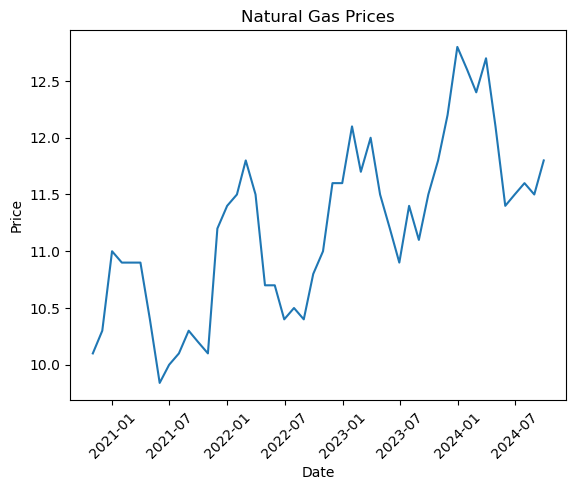

In [40]:

fig, ax = plt.subplots()
ax.plot_date(dates, prices, '-')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Natural Gas Prices')
ax.tick_params(axis='x', rotation=45)

plt.show()

- From the plot - we can see the prices have a natural frequency of around a year, but trend upwards. 
- We can do a linear regression to get the trend, and then fit a sin function to the variation in each year.
- First we need the dates in terms of days from the start, to make it easier to interpolate later.

In [41]:
start_date = date(2020,10,31)
end_date = date(2024,9,30)
months = []
year = start_date.year
month = start_date.month + 1
while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    if current.month == end_date.month and current.year == end_date.year:
        break
    else:
        month = ((month + 1) % 12) or 12
        if month == 1:
            year += 1
        
days_from_start = [(day - start_date ).days for day in months]

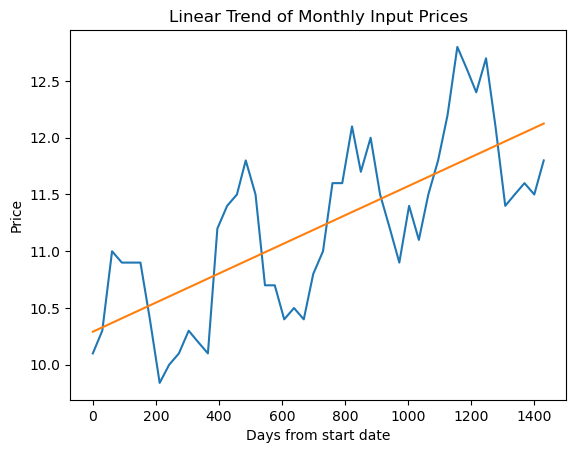

0.001282373598760221 10.29104112595228


In [42]:
# Simple regression for the trend will fit to a model y = Ax + B. The estimator for the slope is given by \hat{A} = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}, 
# and that for the intercept by \hat{B} = \bar{y} - hat{A} * \xbar

def simple_regression(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x - xbar) * (y - ybar))/ np.sum((x - xbar)**2)
    intercept = ybar - slope*xbar
    return slope, intercept

time = np.array(days_from_start)
slope, intercept = simple_regression(time, prices)

# Plot linear trend
plt.plot(time, prices)
plt.plot(time, time * slope + intercept)
plt.xlabel('Days from start date')
plt.ylabel('Price')
plt.title('Linear Trend of Monthly Input Prices')
plt.show()
print(slope, intercept)

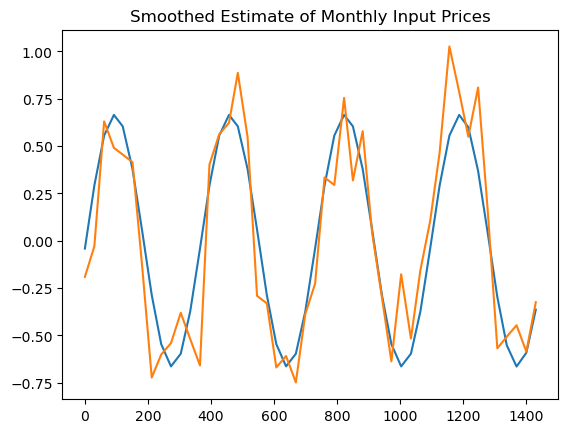

In [43]:
# From this plot we see the linear trend has been captured. Now to fit the intra-year variation. 
# Given that natural gas is used more in winter, and less in summer, we can guess the frequency of the price movements to be about a year, or 12 months.
# Therefore we have a model y = Asin( kt + z ) with a known frequency.Rewriting y = Acos(z)sin(kt) + Asin(z)cos(kt), 
# we can use bilinear regression, with no intercept, to solve for u = Acos(z), w = Asin(z)

sin_prices = prices - (time * slope + intercept)
sin_time = np.sin(time * 2 * np.pi / (365))
cos_time = np.cos(time * 2 * np.pi / (365))

def bilinear_regression(y, x1, x2):
    # Bilinear regression without an intercept amounts to projection onto the x-vectors
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return(slope1, slope2)

slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)

# We now recover the original amplitude and phase shift as A = slope1 ** 2 + slope2 ** 2, z = tan^{-1}(slope2/slope1)
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)

# Plot smoothed estimate of full dataset
plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift))
plt.plot(time, sin_prices)
plt.title('Smoothed Estimate of Monthly Input Prices')
plt.show()

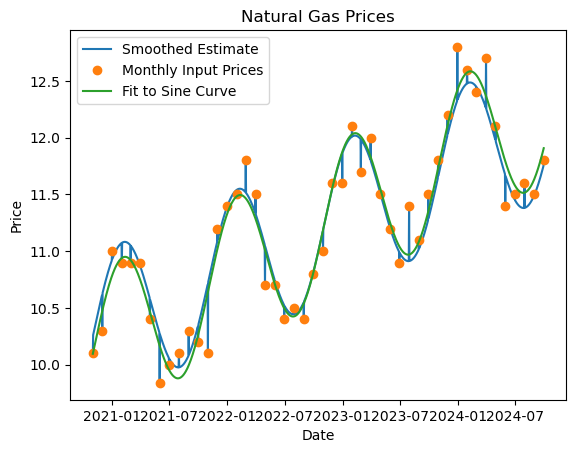

In [44]:
# Define the interpolation/extrapolation function
def interpolate(date):
    days = (date - pd.Timestamp(start_date)).days
    if days in days_from_start:
        # Exact match found in the data
        return prices[days_from_start.index(days)]
    else:
        # Interpolate/extrapolate using the sin/cos model
        return amplitude * np.sin(days * 2 * np.pi / 365 + shift) + days * slope + intercept

# Create a range of continuous dates from start date to end date
continuous_dates = pd.date_range(start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='D')

# Plot the smoothed estimate of the full dataset using interpolation
plt.plot(continuous_dates, [interpolate(date) for date in continuous_dates], label='Smoothed Estimate')

# Fit the monthly input prices to the sine curve
x = np.array(days_from_start)
y = np.array(prices)
fit_amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
fit_shift = np.arctan2(slope2, slope1)
fit_slope, fit_intercept = simple_regression(x, y - fit_amplitude * np.sin(x * 2 * np.pi / 365 + fit_shift))
plt.plot(dates, y, 'o', label='Monthly Input Prices')
plt.plot(continuous_dates, fit_amplitude * np.sin((continuous_dates - pd.Timestamp(start_date)).days * 2 * np.pi / 365 + fit_shift) + (continuous_dates - pd.Timestamp(start_date)).days * fit_slope + fit_intercept, label='Fit to Sine Curve')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices')
plt.legend()
plt.show()


## Now calculating the value of contract

In [32]:
from datetime import date
import math

def price_contract(in_dates, in_prices, out_dates, out_prices, rate, storage_cost_rate, total_vol, injection_withdrawal_cost_rate):
    volume = 0
    buy_cost = 0
    cash_in = 0
    last_date = min(min(in_dates), min(out_dates))
    
    # Ensure dates are in sequence
    all_dates = sorted(set(in_dates + out_dates))
    
    for i in range(len(all_dates)):
        # processing code for each date
        start_date = all_dates[i]

        if start_date in in_dates:
            # Inject on these dates and sum up cash flows
            if volume <= total_vol - rate:
                volume += rate

                # Cost to purchase gas
                buy_cost += rate * in_prices[in_dates.index(start_date)]
                # Injection cost
                injection_cost = rate * injection_withdrawal_cost_rate
                buy_cost += injection_cost
                print('Injected gas on %s at a price of %s'%(start_date, in_prices[in_dates.index(start_date)]))

            else:
                # We do not want to inject when rate is greater than total volume minus volume
                print('Injection is not possible on date %s as there is insufficient space in the storage facility'%start_date)
        elif start_date in out_dates:
            #Withdraw on these dates and sum cash flows
            if volume >= rate:
                volume -= rate
                cash_in += rate * out_prices[out_dates.index(start_date)]
                # Withdrawal cost
                withdrawal_cost = rate * injection_withdrawal_cost_rate
                cash_in -= withdrawal_cost
                print('Extracted gas on %s at a price of %s'%(start_date, out_prices[out_dates.index(start_date)]))
            else:
                # we cannot withdraw more gas than is actually stored
                print('Extraction is not possible on date %s as there is insufficient volume of gas stored'%start_date)
                
    store_cost = math.ceil((max(out_dates) - min(in_dates)).days // 30) * storage_cost_rate
    return cash_in - store_cost - buy_cost

# Example usage of price_contract()
in_dates = [date(2022, 1, 1), date(2022, 2, 1), date(2022, 2, 21), date(2022, 4, 1)] #injection dates
in_prices = [20, 21, 20.5, 22]#prices on the injection days
out_dates = [date(2022, 1, 27), date(2022, 2, 15), date(2022, 3, 20), date(2022, 6, 1)] # extraction dates
out_prices = [23, 19, 21, 25] # prices on the extraction days
rate = 100000  # rate of gas in cubic feet per day
storage_cost_rate = 10000  # total volume in cubic feet
injection_withdrawal_cost_rate = 0.0005  # $/cf
max_storage_volume = 500000 # maximum storage capacity of the storage facility
result = price_contract(in_dates, in_prices, out_dates, out_prices, rate, storage_cost_rate, max_storage_volume, injection_withdrawal_cost_rate)
print()
print(f"The value of the contract is: ${result}")

Injected gas on 2022-01-01 at a price of 20
Extracted gas on 2022-01-27 at a price of 23
Injected gas on 2022-02-01 at a price of 21
Extracted gas on 2022-02-15 at a price of 19
Injected gas on 2022-02-21 at a price of 20.5
Extracted gas on 2022-03-20 at a price of 21
Injected gas on 2022-04-01 at a price of 22
Extracted gas on 2022-06-01 at a price of 25

The value of the contract is: $399600.0
